In [8]:
!pip uninstall -y protobuf
!pip install -q protobuf==4.25.1 flwr[simulation] torch torchvision


Found existing installation: protobuf 6.33.4
Uninstalling protobuf-6.33.4:
  Successfully uninstalled protobuf-6.33.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.0/732.0 kB 58.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.3 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 4.25.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.1 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.1 which is incompatible.
ydf 0.14.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.1 which is incompatible.
grain 0.2.15 requires pr

In [1]:
!pip install -q flwr[simulation] torch torchvision

In [2]:
import flwr as fl
print(f"Flower version: {fl.__version__}")

Flower version: 1.23.0


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader, random_split, Subset
import flwr as fl
from collections import OrderedDict

# Define the Model
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Training/Test logic
def train(net, trainloader, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            criterion(net(images), labels).backward()
            optimizer.step()

def test(net, testloader):
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    return loss / len(testloader.dataset), correct / len(testloader.dataset)

# The Flower Client
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, valloader):
        self.net = Net()
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader, epochs=1)
        return self.get_parameters(config={}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [4]:
# 1. Load CIFAR-10
trf = Compose([ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10("./data", train=True, download=True, transform=trf)
testset = CIFAR10("./data", train=False, download=True, transform=trf)

# 2. CREATE NON-IID DATA (Sort by labels first)
indices = np.argsort(trainset.targets)
sorted_dataset = Subset(trainset, indices)

# Correctly partition for 3 clients
num_clients = 3
partition_size = len(sorted_dataset) // num_clients
lengths = [partition_size] * num_clients
lengths[-1] += len(sorted_dataset) % num_clients

datasets = random_split(sorted_dataset, lengths)
trainloaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in datasets]
testloader = DataLoader(testset, batch_size=32)

# 3. Define how to launch clients
def client_fn(cid: str):
    return FlowerClient(trainloaders[int(cid)], testloader)

# 4. START THE FEDERATED LEARNING
print("\nStarting Federated Learning Simulation (Non-IID)...")
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=fl.server.strategy.FedAvg(),
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Starting Federated Learning Simulation (Non-IID)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-01-28 12:05:51,098	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 3935313100.0, 'node:172.28.0.12': 1.0, 'memory': 7870626203.0, 'accelerator_type:T4': 1.0, 'GPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :     

History (loss, distributed):
	round 1: 0.052621820402145386
	round 2: 0.04540743370056152
	round 3: 0.0417616570353508
	round 4: 0.03961496808528899
	round 5: 0.0381073421895504

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
# 1. Define how to aggregate the accuracy metrics
def weighted_average(metrics):
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

# 2. Use FedProx (The 'Pro' version for biased data)
strategy = fl.server.strategy.FedProx(
    proximal_mu=1.0,  # This forces clients to stay close to the global model
    evaluate_metrics_aggregation_fn=weighted_average,
)

print("\nStarting Federated Learning with FedProx and Accuracy Tracking...")

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=3,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout



Starting Federated Learning with FedProx and Accuracy Tracking...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2026-01-28 12:11:49,269	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'object_store_memory': 3938034892.0, 'node:172.28.0.12': 1.0, 'memory': 7876069787.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :     

History (loss, distributed):
	round 1: 0.05084969596862793
	round 2: 0.04482801135778427
	round 3: 0.041476793479919435
	round 4: 0.038845274806022644
	round 5: 0.03811396952271461
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.4111), (2, 0.4902), (3, 0.5242), (4, 0.5604), (5, 0.5704)]}

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


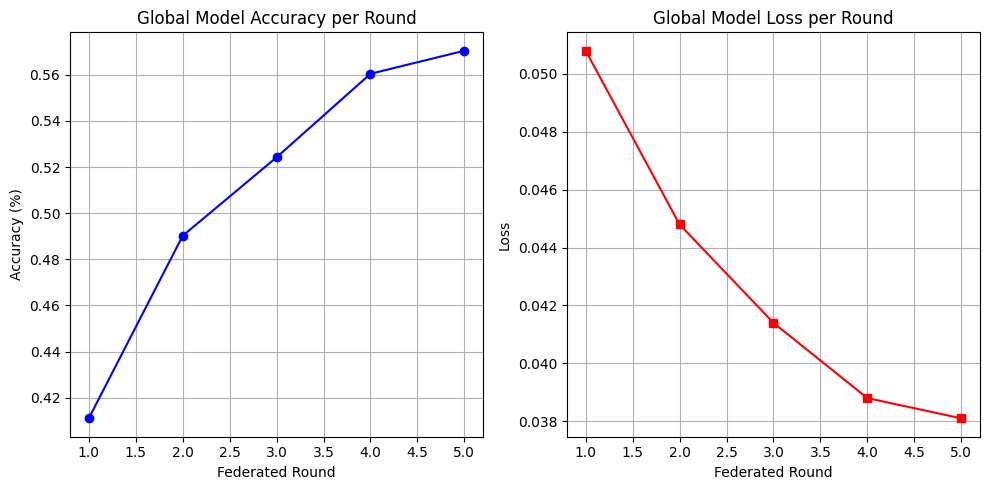

In [6]:
import matplotlib.pyplot as plt

# 1. Extract data
rounds = [1, 2, 3, 4, 5]
accuracy = [0.4111, 0.4902, 0.5242, 0.5604, 0.5704]
loss = [0.0508, 0.0448, 0.0414, 0.0388, 0.0381]

# 2. Plot Accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(rounds, accuracy, marker='o', color='b', label='Accuracy')
plt.title('Global Model Accuracy per Round')
plt.xlabel('Federated Round')
plt.ylabel('Accuracy (%)')
plt.grid(True)

# 3. Plot Loss
plt.subplot(1, 2, 2)
plt.plot(rounds, loss, marker='s', color='r', label='Loss')
plt.title('Global Model Loss per Round')
plt.xlabel('Federated Round')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()